# 🤖 Classification d'images de déchets - TEKBOT Robotics Challenge

## 🎯 Objectif
Dans ce notebook, nous allons apprendre à créer un système de classification d'images pour trier automatiquement les moyens de transport. Notre robot devra être capable de reconnaître 3 types de moyens de transport :
- ♻️ **Voiture**
- 🟦 **Bateau**
- 🟥 **Camion**

## 🧠 Qu'est-ce que la classification d'images ?
La classification d'images est une tâche d'intelligence artificielle qui consiste à :
1. **Prendre une image en entrée**
2. **Analyser son contenu** avec un réseau de neurones
3. **Prédire une catégorie** parmi plusieurs classes possibles

Pour ce défi, nous utiliserons le dataset CIFAR-10.


## 1. Imports et configuration

In [ ]:
# Imports nécessaires
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé : {device}")

# Pour la reproductibilité
torch.manual_seed(42)
np.random.seed(42)

Device utilisé : cuda


## 2. 📊 Exploration du dataset CIFAR-10

CIFAR-10 contient 60 000 images couleur de 32x32 pixels réparties en 10 classes. Pour notre simulation, nous allons utiliser :

- **Classe 1 (automobile)** → Voiture
- **Classe 8 (ship)** → Bateau  
- **Classe 9 (truck)** → Camion

Pourquoi ce choix ? Dans le cadre du TRC, on aurait des images de vrais déchets dans plusieurs conditions, mais CIFAR-10 nous permet d'apprendre les concepts de base !

In [ ]:
# Transformation de base pour normaliser les images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisation [-1, 1]
])

# Chargement du dataset complet CIFAR-10
full_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
full_testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# Classes CIFAR-10 originales
cifar10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Nos classes cibles et leurs nouveaux labels
target_classes = {
    1: 0,  # automobile → Voiture
    8: 1,  # ship → Bateau
    9: 2   # truck → Camion
}

# Nouveaux noms de classes
waste_classes = ['Voiture', 'Bateau', 'Camion']

print(f"Classes sélectionnées :")
for original_idx, new_idx in target_classes.items():
    print(f"  {cifar10_classes[original_idx]} → {waste_classes[new_idx]}")

Classes sélectionnées :
  car → Voiture
  ship → Bateau
  truck → Camion


## Filtrage et création des datasets

In [ ]:
def filter_dataset(dataset, target_classes):
    """Filtre le dataset pour ne garder que les classes cibles"""
    indices = []
    new_targets = []

    for idx, (_, target) in enumerate(dataset):
        if target in target_classes:
            indices.append(idx)
            new_targets.append(target_classes[target])

    # Créer un subset
    filtered_dataset = Subset(dataset, indices)

    # Remplacer les targets
    for i, new_target in enumerate(new_targets):
        filtered_dataset.dataset.targets[filtered_dataset.indices[i]] = new_target

    return filtered_dataset

# Filtrage des datasets
train_dataset = filter_dataset(full_trainset, target_classes)
test_dataset = filter_dataset(full_testset, target_classes)

print(f"Dataset d'entraînement : {len(train_dataset)} images")
print(f"Dataset de test : {len(test_dataset)} images")

Dataset d'entraînement : 15000 images
Dataset de test : 3000 images


## 3. Visualisation des données

🖼️ Exemples d'images par classe :


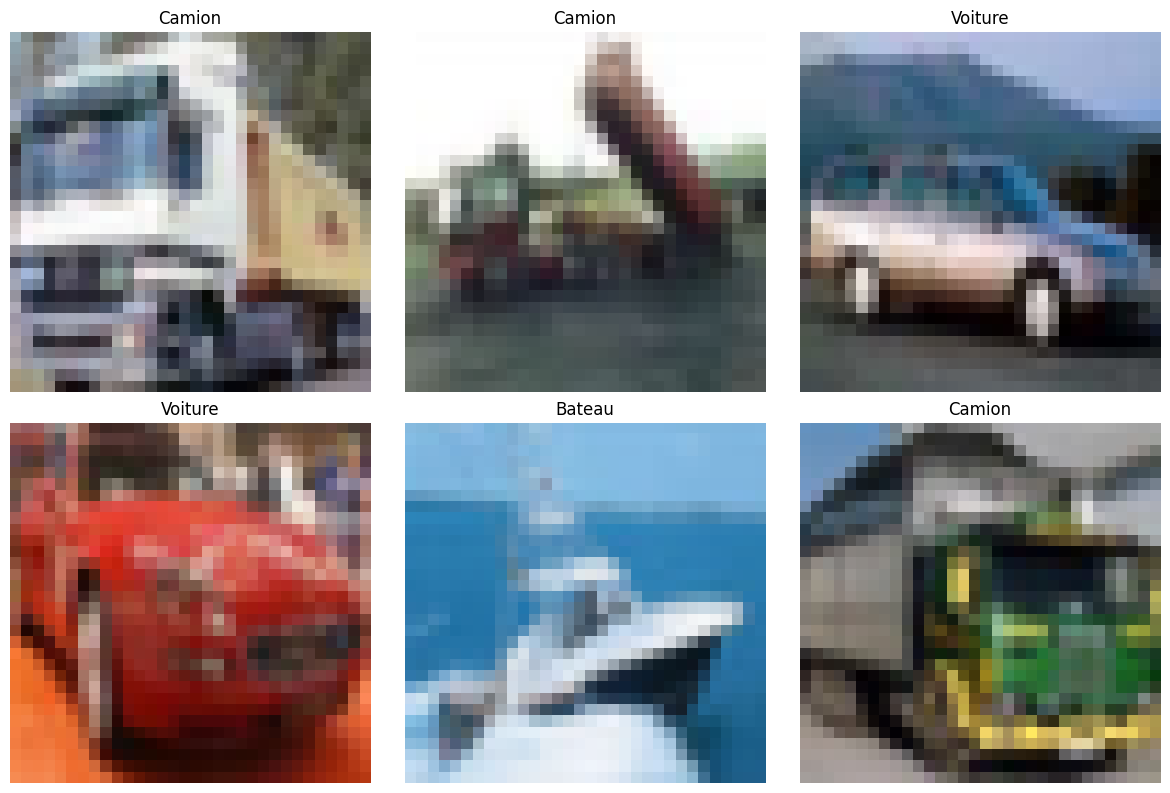

In [ ]:
# Fonction pour afficher des images
def show_images(dataset, num_samples=6):
    """Affiche quelques échantillons du dataset"""
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        img, label = dataset[i]

        # Dénormaliser l'image pour l'affichage
        img = img * 0.5 + 0.5
        img = torch.clamp(img, 0, 1)

        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].set_title(f'{waste_classes[label]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualisation d'échantillons de chaque classe
print("🖼️ Exemples d'images par classe :")
show_images(train_dataset)

## 4. 🧠 Comment fonctionne un CNN (Réseau de Neurones Convolutionnel) ?

Un CNN analyse les images étape par étape :

## 1. 🔍 Couches de Convolution
- **Rôle** : Détecter des motifs locaux (bords, formes, textures)
- **Principe** : Un filtre glisse sur l'image pour créer une "carte de caractéristiques"

## 2. ⚡ Fonction d'activation (ReLU)
- **Rôle** : Introduire de la non-linéarité
- **Principe** : ReLU(x) = max(0, x) - garde seulement les valeurs positives

## 3. 📉 Pooling (sous-échantillonnage)
- **Rôle** : Réduire la taille des images et garder l'information importante
- **Principe** : MaxPooling garde la valeur maximale dans chaque région

## 4. 🎯 Couches entièrement connectées
- **Rôle** : Combiner toutes les informations pour la classification finale
- **Principe** : Comme un réseau de neurones classique

## 🔄 Notre architecture

# **Image (3x32x32) → Conv+ReLU+Pool → Conv+ReLU+Pool → Flatten → FC → 3 classes**

## 5. Préparation des DataLoaders

In [ ]:
# Séparation train/validation (80%/20%)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

# Création des DataLoaders
batch_size = 32

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"📊 Répartition des données :")
print(f"  Entraînement : {len(train_subset)} images")
print(f"  Validation : {len(val_subset)} images")
print(f"  Test : {len(test_dataset)} images")
print(f"  Taille des batchs : {batch_size}")

📊 Répartition des données :
  Entraînement : 12000 images
  Validation : 3000 images
  Test : 3000 images
  Taille des batchs : 32


## 6. Définition du modèle CNN

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()

        # Premier bloc convolutionnel
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 3→16 canaux
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 → 16x16

        # Deuxième bloc convolutionnel
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16→32 canaux
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 → 8x8

        # Troisième bloc convolutionnel
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32→64 canaux
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 → 4x4

        # Couches entièrement connectées
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  # 64 canaux × 4×4 pixels
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Premier bloc : Conv → ReLU → Pool
        x = self.pool1(F.relu(self.conv1(x)))

        # Deuxième bloc : Conv → ReLU → Pool
        x = self.pool2(F.relu(self.conv2(x)))

        # Troisième bloc : Conv → ReLU → Pool
        x = self.pool3(F.relu(self.conv3(x)))

        # Aplatir pour les couches FC
        x = x.view(-1, 64 * 4 * 4)

        # Couches entièrement connectées
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Création du modèle
model = SimpleCNN(num_classes=3).to(device)

# Affichage de l'architecture
print("🏗️ Architecture du modèle :")
print(model)

# Comptage des paramètres
total_params = sum(p.numel() for p in model.parameters())
print(f"\n📊 Nombre total de paramètres : {total_params:,}")

🏗️ Architecture du modèle :
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

📊 Nombre total de paramètres : 155,171


## 7. Configuration de l'entraînement


In [ ]:
# Configuration de l'entraînement
criterion = nn.CrossEntropyLoss()  # Fonction de perte pour classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimiseur Adam

# Pour suivre les métriques
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("⚙️ Configuration de l'entraînement :")
print(f"  Fonction de perte : {criterion}")
print(f"  Optimiseur : Adam (lr=0.001)")
print(f"  Device : {device}")

⚙️ Configuration de l'entraînement :
  Fonction de perte : CrossEntropyLoss()
  Optimiseur : Adam (lr=0.001)
  Device : cuda


## 8. Fonctions d'entraînement et validation

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entraîne le modèle sur une époque"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Remise à zéro des gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass et optimisation
        loss.backward()
        optimizer.step()

        # Statistiques
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Affichage du progrès
        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Évalue le modèle sur le dataset de validation"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

## 9. Boucle d'entraînement

In [ ]:
# Entraînement du modèle
num_epochs = 20

print("🚀 Début de l'entraînement !")
print("-" * 50)

for epoch in range(num_epochs):
    print(f'\nÉpoque {epoch+1}/{num_epochs}')
    print("-" * 30)

    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Sauvegarde des métriques
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Affichage des résultats
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

print("\n✅ Entraînement terminé !")

🚀 Début de l'entraînement !
--------------------------------------------------

Époque 1/20
------------------------------
Batch 0/375 - Loss: 1.0932
Batch 10/375 - Loss: 1.0732
Batch 20/375 - Loss: 1.0025
Batch 30/375 - Loss: 0.9845
Batch 40/375 - Loss: 0.9911
Batch 50/375 - Loss: 0.9438
Batch 60/375 - Loss: 1.0066
Batch 70/375 - Loss: 1.1071
Batch 80/375 - Loss: 0.8919
Batch 90/375 - Loss: 0.7624
Batch 100/375 - Loss: 0.7015
Batch 110/375 - Loss: 0.8674
Batch 120/375 - Loss: 0.8666
Batch 130/375 - Loss: 0.6568
Batch 140/375 - Loss: 0.7988
Batch 150/375 - Loss: 0.9032
Batch 160/375 - Loss: 0.9182
Batch 170/375 - Loss: 0.6960
Batch 180/375 - Loss: 0.5449
Batch 190/375 - Loss: 0.4239
Batch 200/375 - Loss: 0.6798
Batch 210/375 - Loss: 0.6653
Batch 220/375 - Loss: 0.6507
Batch 230/375 - Loss: 0.8423
Batch 240/375 - Loss: 0.7113
Batch 250/375 - Loss: 0.7859
Batch 260/375 - Loss: 0.6900
Batch 270/375 - Loss: 0.6928
Batch 280/375 - Loss: 0.6998
Batch 290/375 - Loss: 0.7600
Batch 300/375 - Lo

## 10. Visualisation des courbes d'apprentissage

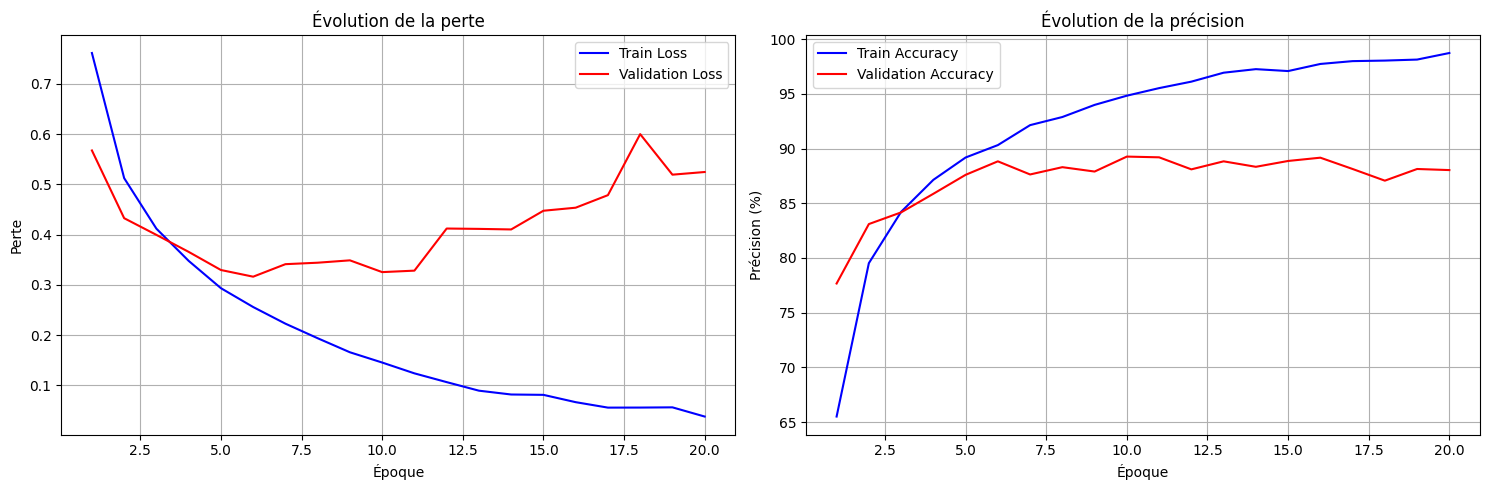

📊 Résultats finaux :
  Précision d'entraînement : 98.73%
  Précision de validation : 88.03%


In [ ]:
# Visualisation des courbes d'apprentissage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Courbe de perte
ax1.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss')
ax1.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
ax1.set_xlabel('Époque')
ax1.set_ylabel('Perte')
ax1.set_title('Évolution de la perte')
ax1.legend()
ax1.grid(True)

# Courbe de précision
ax2.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Train Accuracy')
ax2.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Précision (%)')
ax2.set_title('Évolution de la précision')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Résumé final
print(f"📊 Résultats finaux :")
print(f"  Précision d'entraînement : {train_accuracies[-1]:.2f}%")
print(f"  Précision de validation : {val_accuracies[-1]:.2f}%")

## 11. Évaluation sur le dataset de test


In [ ]:
def evaluate_model(model, test_loader, device):
    """Évalue le modèle sur le dataset de test"""
    model.eval()
    all_predictions = []
    all_targets = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    return accuracy, all_predictions, all_targets

# Évaluation
test_accuracy, predictions, targets = evaluate_model(model, test_loader, device)

print(f"🎯 Précision sur le dataset de test : {test_accuracy:.2f}%")

# Rapport de classification détaillé
print("\n📋 Rapport de classification :")
print(classification_report(targets, predictions, target_names=waste_classes))

🎯 Précision sur le dataset de test : 88.73%

📋 Rapport de classification :
              precision    recall  f1-score   support

     Voiture       0.88      0.86      0.87      1000
      Bateau       0.94      0.90      0.92      1000
      Camion       0.84      0.91      0.87      1000

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



## 12. Matrice de confusion

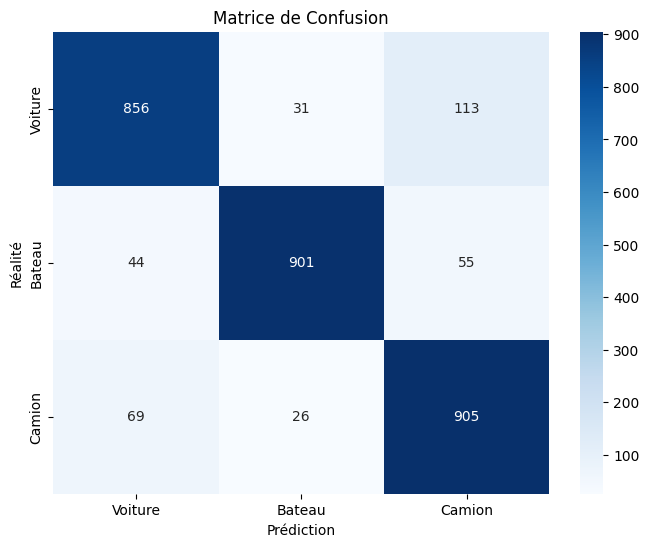

🔍 Analyse des erreurs :
  Voiture: 85.6% de précision (856/1000)
  Bateau: 90.1% de précision (901/1000)
  Camion: 90.5% de précision (905/1000)


In [ ]:
# Matrice de confusion
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=waste_classes, yticklabels=waste_classes)
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.show()

# Analyse des erreurs
print("🔍 Analyse des erreurs :")
for i, class_name in enumerate(waste_classes):
    correct_pred = cm[i, i]
    total_class = cm[i, :].sum()
    accuracy_class = correct_pred / total_class * 100
    print(f"  {class_name}: {accuracy_class:.1f}% de précision ({correct_pred}/{total_class})")

## 13. Visualisation des erreurs

❌ Exemples d'erreurs de classification :


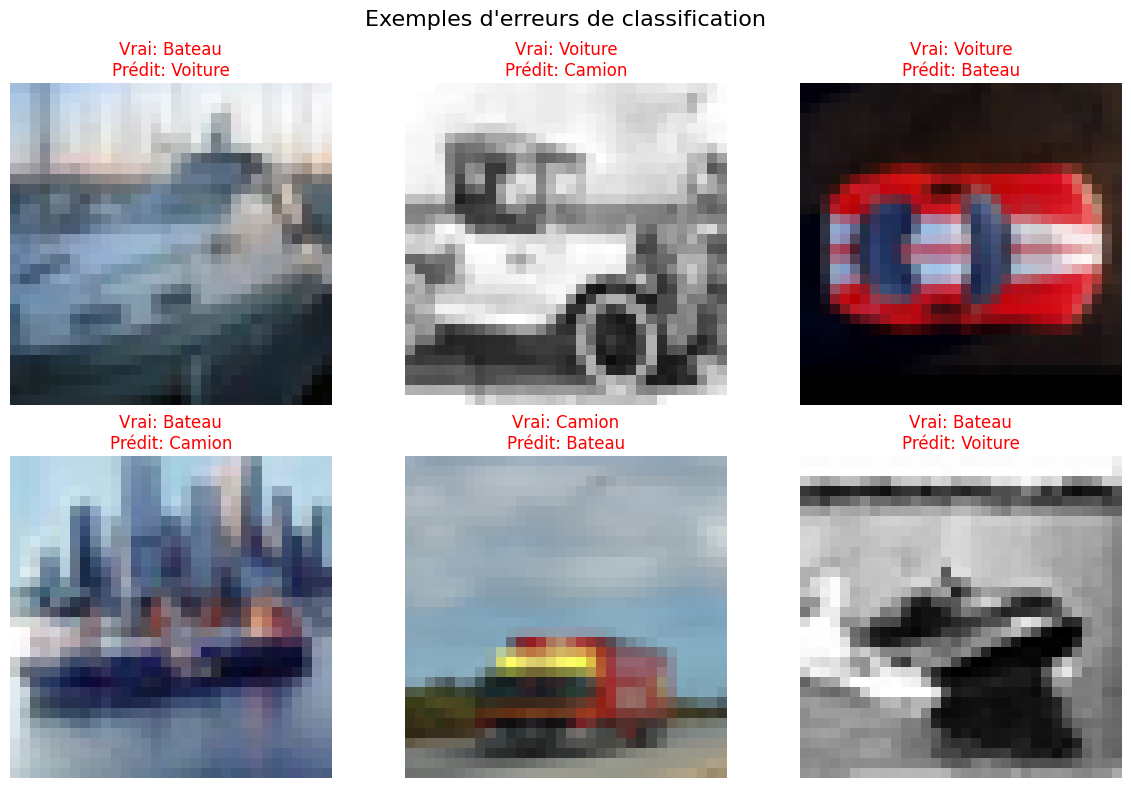

In [ ]:
def show_misclassified_images(model, test_dataset, device, num_images=6):
    """Affiche des exemples d'images mal classifiées"""
    model.eval()
    misclassified = []

    with torch.no_grad():
        for i, (img, true_label) in enumerate(test_dataset):
            img_batch = img.unsqueeze(0).to(device)
            output = model(img_batch)
            predicted_label = output.argmax(1).item()

            if predicted_label != true_label:
                misclassified.append((img, true_label, predicted_label))

            if len(misclassified) >= num_images:
                break

    if len(misclassified) == 0:
        print("🎉 Aucune erreur trouvée dans les premiers échantillons !")
        return

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for i, (img, true_label, pred_label) in enumerate(misclassified):
        # Dénormaliser l'image
        img = img * 0.5 + 0.5
        img = torch.clamp(img, 0, 1)

        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].set_title(f'Vrai: {waste_classes[true_label]}\nPrédit: {waste_classes[pred_label]}',
                         color='red')
        axes[i].axis('off')

    plt.suptitle('Exemples d\'erreurs de classification', fontsize=16)
    plt.tight_layout()
    plt.show()

print("❌ Exemples d'erreurs de classification :")
show_misclassified_images(model, test_dataset, device)

# 🖼️ Test sur une nouvelle image

Maintenant que notre modèle est entraîné, testons-le sur une nouvelle image !

Dans un vrai projet robotique, cette partie serait connectée à la caméra du robot.

## 14. Fonction de prédiction

In [ ]:
def predict_image(model, image_path, device, transform):
    """Prédit la classe d'une image externe"""
    from PIL import Image

    # Charger et transformer l'image
    image = Image.open(image_path).convert('RGB')
    image = image.resize((32, 32))  # CIFAR-10 utilise 32x32

    # Appliquer les transformations
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Prédiction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = output.argmax(1).item()
        confidence = probabilities[0][predicted_class].item()

    return predicted_class, confidence, probabilities[0]

# Exemple d'utilisation (décommentez si vous avez une image)

# Chemin vers votre image
# image_path = "mon_image.jpg"

# try:
#     pred_class, confidence, all_probs = predict_image(model, image_path, device, transform)

#     print(f"🎯 Prédiction : {waste_classes[pred_class]}")
#     print(f"🎯 Confiance : {confidence:.2%}")
#     print(f"\n📊 Probabilités pour chaque classe :")
#     for i, prob in enumerate(all_probs):
#         print(f"  {waste_classes[i]}: {prob:.2%}")

# except FileNotFoundError:
#     print("❌ Image non trouvée. Placez votre image dans le bon répertoire !")

print("💡 Pour tester une image, décommentez le code ci-dessus et ajoutez le chemin de votre image.")

💡 Pour tester une image, décommentez le code ci-dessus et ajoutez le chemin de votre image.


## 15. Export du modèle

In [ ]:
# Sauvegarde du modèle
model_path = "waste_classifier_model.pt"

# Sauvegarder le state_dict (recommandé)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'classes': waste_classes
}, model_path)

print(f"✅ Modèle sauvegardé dans {model_path}")

# Optionnel : Export pour Jetson Nano (ONNX)
try:
    # Exemple d'entrée pour le traçage
    dummy_input = torch.randn(1, 3, 32, 32).to(device)

    # Export ONNX
    onnx_path = "waste_classifier_model.onnx"
    torch.onnx.export(model, dummy_input, onnx_path,
                      input_names=['input'], output_names=['output'],
                      dynamic_axes={'input': {0: 'batch_size'},
                                   'output': {0: 'batch_size'}})

    print(f"✅ Modèle ONNX sauvegardé dans {onnx_path}")

except Exception as e:
    print(f"⚠️ Erreur lors de l'export ONNX : {e}")

✅ Modèle sauvegardé dans waste_classifier_model.pt
⚠️ Erreur lors de l'export ONNX : Module onnx is not installed!


## 16. Conclusion et prochaines étapes

# 🎉 Félicitations ! Vous avez créé votre premier classificateur d'images !

## 📝 Ce que vous avez appris :
- ✅ Charger et préparer un dataset d'images
- ✅ Créer un réseau de neurones convolutionnel (CNN)
- ✅ Entraîner un modèle de classification
- ✅ Évaluer les performances avec des métriques
- ✅ Visualiser les résultats et analyser les erreurs
- ✅ Sauvegarder et exporter le modèle

## 🚀 Prochaines étapes pour le challenge TEKBOT :

### 1. 🔧 Améliorations possibles :
- **Plus de données** : Utiliser un dataset de vrais déchets
- **Data Augmentation** : Rotation, zoom, luminosité pour plus de robustesse
- **Architecture plus complexe** : ResNet, EfficientNet
- **Optimisation des hyperparamètres** : Learning rate, batch size, etc.

### 2. 🤖 Intégration robot :
- **Caméra** : Connecter une caméra au Jetson Nano
- **Temps réel** : Optimiser la vitesse d'inférence
- **Actions** : Programmer le bras robotique selon la prédiction

### 3. 📚 Défis avancés :
- Gérer plusieurs objets dans une image
- Classification en temps réel
- Interface utilisateur pour contrôler le robot

## 💡 Questions de réflexion :
- Comment améliorer la précision sur la classe la moins bien reconnue ?
- Quels autres types de déchets pourriez-vous ajouter ?
- Comment adapter ce code pour d'autres tâches de classification ?

**Prêt pour le Notebook 2 sur la détection d'objets ? 🎯**